In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from itertools import product
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.model_selection import train_test_split


In [5]:
df= pd.read_csv('ETH_1H.csv')
print(df.info())
print(df.head())
yt,yf=train_test_split(df.Close,shuffle=False,test_size=0.3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34497 entries, 0 to 34496
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unix Timestamp  34497 non-null  int64  
 1   Date            34497 non-null  object 
 2   Symbol          34497 non-null  object 
 3   Open            34497 non-null  float64
 4   High            34497 non-null  float64
 5   Low             34497 non-null  float64
 6   Close           34497 non-null  float64
 7   Volume          34497 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.1+ MB
None
   Unix Timestamp                 Date  Symbol    Open    High     Low  \
0   1586995200000  2020-04-16 00:00:00  ETHUSD  152.94  152.94  150.39   
1   1586991600000  2020-04-15 23:00:00  ETHUSD  155.81  155.81  151.39   
2   1586988000000  2020-04-15 22:00:00  ETHUSD  157.18  157.30  155.32   
3   1586984400000  2020-04-15 21:00:00  ETHUSD  158.04  158.31  157.16   
4   1

In [6]:
yt.head()

0    150.39
1    152.94
2    155.81
3    157.18
4    158.04
Name: Close, dtype: float64

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month']=df['Date'].dt.month
df['Day']=df['Date'].dt.day
df['Year']=df['Date'].dt.year
df['Hour']=df['Date'].dt.hour
df['Minute']=df['Date'].dt.minute
df['Second']=df['Date'].dt.second

In [8]:
df_train,df_test=train_test_split(df.Close,shuffle=False,test_size=0.3)
 
print('train shape :', df_train.shape)
print('validation shape :', df_test.shape)

train shape : (24147,)
validation shape : (10350,)


In [9]:
df["Close_LogT"]= np.log(df['Close'])
def differencing(dataset):
    diff_close=[]
    for i in range(0,len(dataset)):
        if i==0:
            diff_close.append(df.Close_LogT[0])
        else:
            value= dataset[i]-dataset[i-1]
            diff_close.append(value)
    return diff_close

df["Differential_close"]=differencing(df.Close_LogT)

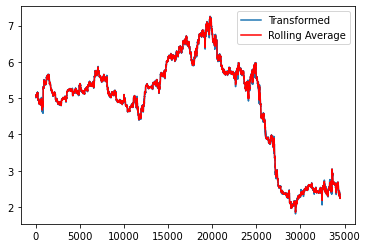

In [10]:
Rolling_average = df["Close_LogT"].rolling(window = 7, center= False).mean()
plt.plot(df["Close_LogT"], label = 'Transformed')
plt.plot(Rolling_average, color = 'red', label = 'Rolling Average')
plt.legend(loc = 'best')

In [11]:
log_Rolling_difference= df["Close_LogT"] - Rolling_average

log_Rolling_difference.head(15)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6     0.014025
7     0.005541
8    -0.000600
9    -0.008973
10   -0.000546
11   -0.002717
12   -0.002837
13    0.003770
14    0.005103
Name: Close_LogT, dtype: float64

In [12]:
log_Rolling_difference.dropna(axis=0,inplace=True)
log_Rolling_difference.head()

6     0.014025
7     0.005541
8    -0.000600
9    -0.008973
10   -0.000546
Name: Close_LogT, dtype: float64

In [13]:
def ADF_Cal(x):
    result = adfuller(x)
    print("ADF Statistic: %f" %result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [14]:
ADF_Cal(log_Rolling_difference)


ADF Statistic: -30.973650
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [15]:
kpss_test(log_Rolling_difference)

Results of KPSS Test:
Test Statistic            0.534718
p-value                   0.033847
Lags Used                55.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


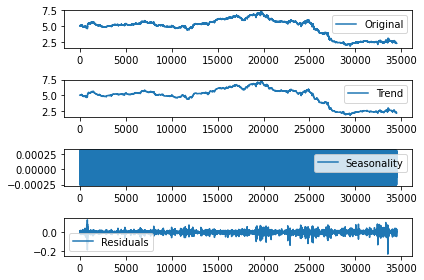

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
decomposition = seasonal_decompose(df["Close_LogT"], period=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df["Close_LogT"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [17]:
from statsmodels.tsa.stattools import acf, pacf

#ACF and PACF plots:
lag_acf = acf(log_Rolling_difference, nlags=100)
lag_pacf = pacf(log_Rolling_difference, nlags=100, method='ols')

/Users/sagartripathi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Autocorrelation Function')

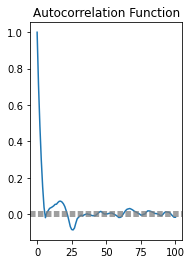

In [18]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_Rolling_difference)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_Rolling_difference)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

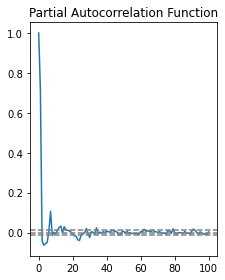

In [19]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_Rolling_difference)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_Rolling_difference)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [20]:
from statsmodels.tsa.arima_model import ARIMA

In [21]:
log_Rolling_difference = log_Rolling_difference.fillna(0)

/Users/sagartripathi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


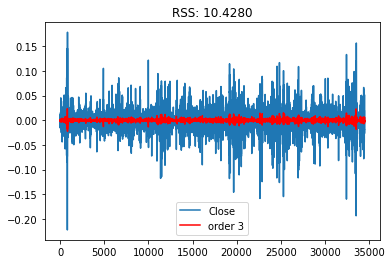

In [22]:
model = ARIMA(df["Close_LogT"], order=(3, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(log_Rolling_difference, label ='Close')
plt.plot(results_AR.fittedvalues, color='red', label = 'order 3')
RSS = results_AR.fittedvalues-log_Rolling_difference
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc = 'best')

Text(0.5, 1.0, 'RSS: 10.4096')

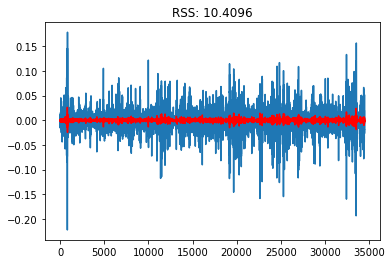

In [23]:
#MA model
model = ARIMA(df["Close_LogT"], order=(0, 1,18)) 
results_MA = model.fit(disp=-1)  
plt.plot(log_Rolling_difference)
plt.plot(results_MA.fittedvalues, color='red')
RSS = results_MA.fittedvalues-log_Rolling_difference
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))

In [24]:
print(results_MA.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Close_LogT   No. Observations:                34496
Model:                ARIMA(0, 1, 18)   Log Likelihood              100063.071
Method:                       css-mle   S.D. of innovations              0.013
Date:                Wed, 04 May 2022   AIC                        -200086.143
Time:                        11:15:46   BIC                        -199917.171
Sample:                             1   HQIC                       -200032.284
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -7.942e-05   7.19e-05     -1.105      0.269      -0.000    6.14e-05
ma.L1.D.Close_LogT     -0.1003      0.005    -18.630      0.000      -0.111      -0.090
ma.L2.D.Close_Lo

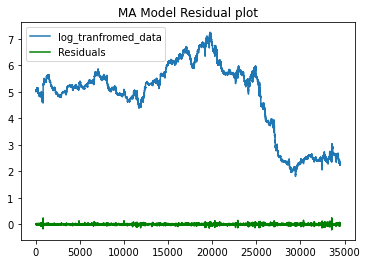

In [25]:
plt.plot(df["Close_LogT"], label = 'log_tranfromed_data')
plt.plot(results_MA.resid, color ='green',label= 'Residuals')
plt.title('MA Model Residual plot')
plt.legend(loc = 'best')

count    3.449600e+04
mean    -1.234692e-07
std      1.330468e-02
min     -2.140426e-01
25%     -4.205357e-03
50%      5.683359e-05
75%      4.155372e-03
max      2.435922e-01
dtype: float64


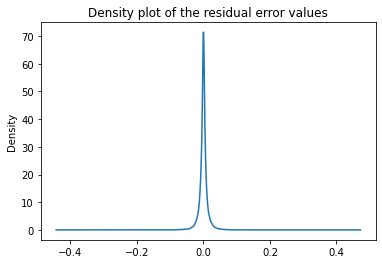

In [26]:
results_MA.resid.plot(kind='kde')
plt.title('Density plot of the residual error values')
print(results_MA.resid.describe())

/Users/sagartripathi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


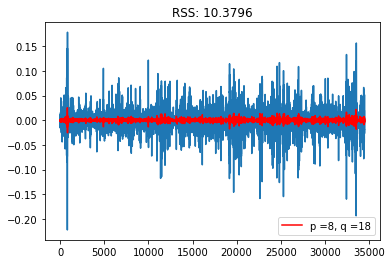

In [27]:
#ARIMA Combined model
model = ARIMA(df["Close_LogT"], order=(3, 1, 18))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(log_Rolling_difference)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =8, q =18')
RSS =results_ARIMA.fittedvalues-log_Rolling_difference
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')

In [32]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Close_LogT   No. Observations:                34496
Model:                ARIMA(3, 1, 18)   Log Likelihood              100101.010
Method:                       css-mle   S.D. of innovations              0.013
Date:                Wed, 04 May 2022   AIC                        -200158.019
Time:                        01:54:38   BIC                        -199972.150
Sample:                             1   HQIC                       -200098.775
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
ar.L1.D.Close_LogT      0.7173      0.028     25.401      0.000       0.662       0.773
ar.L2.D.Close_LogT      0.8527      0.016     52.158      0.000       0.821       0.885
ar.L3.D.Close_Lo

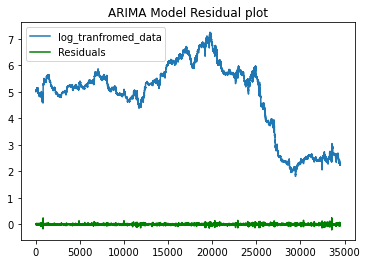

In [29]:
plt.plot(df["Close_LogT"], label = 'log_tranfromed_data')
plt.plot(results_ARIMA.resid, color ='green',label= 'Residuals')
plt.title('ARIMA Model Residual plot')
plt.legend(loc = 'best')

count    3.449600e+04
mean    -7.976908e-05
std      1.328981e-02
min     -2.137656e-01
25%     -4.312412e-03
50%      1.138895e-07
75%      4.073177e-03
max      2.457584e-01
dtype: float64


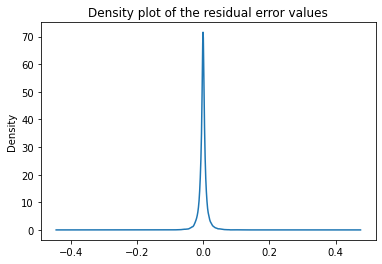

In [30]:
results_ARIMA.resid.plot(kind='kde')
plt.title('Density plot of the residual error values')
print(results_ARIMA.resid.describe())

In [31]:
train, test = train_test_split(df,shuffle=False,test_size=0.3)

In [32]:
train.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume,Month,Day,Year,Hour,Minute,Second,Close_LogT,Differential_close
0,1586995200000,2020-04-16 00:00:00,ETHUSD,152.94,152.94,150.39,150.39,650.188125,4,16,2020,0,0,0,5.013232,5.013232
1,1586991600000,2020-04-15 23:00:00,ETHUSD,155.81,155.81,151.39,152.94,4277.567299,4,15,2020,23,0,0,5.030046,0.016814
2,1586988000000,2020-04-15 22:00:00,ETHUSD,157.18,157.30,155.32,155.81,106.337279,4,15,2020,22,0,0,5.048637,0.018592
3,1586984400000,2020-04-15 21:00:00,ETHUSD,158.04,158.31,157.16,157.18,55.244131,4,15,2020,21,0,0,5.057392,0.008754
4,1586980800000,2020-04-15 20:00:00,ETHUSD,157.10,158.10,156.87,158.04,144.262622,4,15,2020,20,0,0,5.062848,0.005457


In [33]:
test.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume,Month,Day,Year,Hour,Minute,Second,Close_LogT,Differential_close
24147,1500055200,2017-07-14 18:00:00,ETHUSD,189.15,194.84,187.31,194.72,10905.362740,7,14,2017,18,0,0,5.271563,0.014953
24148,1500051600,2017-07-14 17:00:00,ETHUSD,184.28,189.61,181.20,189.15,10822.592570,7,14,2017,17,0,0,5.242540,-0.029022
24149,1500048000,2017-07-14 16:00:00,ETHUSD,188.43,190.00,183.50,184.28,19446.509810,7,14,2017,16,0,0,5.216456,-0.026084
24150,1500044400,2017-07-14 15:00:00,ETHUSD,191.20,193.00,188.00,188.43,9557.896675,7,14,2017,15,0,0,5.238727,0.022270
24151,1500040800,2017-07-14 14:00:00,ETHUSD,191.00,194.00,187.47,191.20,16434.922050,7,14,2017,14,0,0,5.253320,0.014593


In [34]:
Test_y=test.Close
test.drop(columns='Close', inplace=True)
test.head()

/Users/sagartripathi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Unix Timestamp,Date,Symbol,Open,High,Low,Volume,Month,Day,Year,Hour,Minute,Second,Close_LogT,Differential_close
24147,1500055200,2017-07-14 18:00:00,ETHUSD,189.15,194.84,187.31,10905.362740,7,14,2017,18,0,0,5.271563,0.014953
24148,1500051600,2017-07-14 17:00:00,ETHUSD,184.28,189.61,181.20,10822.592570,7,14,2017,17,0,0,5.242540,-0.029022
24149,1500048000,2017-07-14 16:00:00,ETHUSD,188.43,190.00,183.50,19446.509810,7,14,2017,16,0,0,5.216456,-0.026084
24150,1500044400,2017-07-14 15:00:00,ETHUSD,191.20,193.00,188.00,9557.896675,7,14,2017,15,0,0,5.238727,0.022270
24151,1500040800,2017-07-14 14:00:00,ETHUSD,191.00,194.00,187.47,16434.922050,7,14,2017,14,0,0,5.253320,0.014593


In [35]:
Test_y.tail()

34492     9.49
34493     9.83
34494     9.99
34495    10.00
34496     9.55
Name: Close, dtype: float64

In [36]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

1    0.000000
2   -0.001558
3   -0.002514
4   -0.002043
5   -0.001191
dtype: float64


In [37]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

1    0.000000
2   -0.001558
3   -0.004071
4   -0.006115
5   -0.007306
dtype: float64


In [38]:
predictions_ARIMA_log = pd.Series(df.Close_LogT.iloc[0], index=df.Close_LogT.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

0    5.013232
1    5.013232
2    5.011674
3    5.009160
4    5.007117
dtype: float64

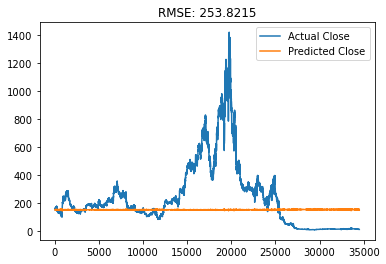

In [39]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df.Close,label='Actual Close')
plt.plot(predictions_ARIMA, label='Predicted Close')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df.Close)**2)/len(df.Close)))
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error
dates=test.index
forecast = pd.Series(results_ARIMA.forecast(steps=10350)[0],dates)
forecast = 10**(forecast+test.Differential_close)
print(forecast)
error = mean_squared_error(Test_y, forecast)
print('Test MSE: %.3f' % error)

24147    189.934534
24148    172.129325
24149    174.052931
24150    194.150458
24151    192.019510
            ...    
34492    192.711958
34493    202.449013
34494    193.758606
34495    187.118119
34496    167.908006
Length: 10350, dtype: float64
Test MSE: 25741.871


In [45]:
len(test.index)

10350